# Target Trial Emulation in Python (TTE‑v1)

This notebook replicates the key steps of the "Target Trial Emulation in R" tutorial by Alan Yang using Python. The analysis includes:

1. Loading and inspecting the dummy data.
2. Calculating inverse probability of censoring weights (IPCW).
3. Expanding the observational data into a sequence of trial entries.
4. Fitting a marginal structural outcome model (MSM) using weighted logistic regression.
5. Generating predictions and plotting the results.

*Note:* This is a simplified version designed to mimic the R tutorial’s workflow.


In [20]:
# Step 1: Data Preparation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load the dummy data (make sure 'data_censored.csv' is in your working directory)
data = pd.read_csv("data_censored.csv")
print("Data Head:")
print(data.head())
print("\nData Shape:", data.shape)


Data Head:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

Data Shape: (725, 12)


## Data Inspection

The dataset should contain columns such as:
- `id`: Patient identifier
- `period`: Time period
- `treatment`: Indicator of treatment (1 = treated, 0 = not treated)
- `x1`, `x2`, `x3`, `x4`: Covariates
- `age`, `age_s`: Age variables
- `outcome`: Outcome indicator (e.g., survival event)
- `censored`: Censoring indicator (1 = censored, 0 = not censored)
- `eligible`: Indicator of trial eligibility

Review the output above to ensure the data loaded correctly.


## Step 2: Calculate Inverse Probability of Censoring Weights (IPCW)

We model the probability of being uncensored using covariates (here, `x2` and `x1`). We then compute weights as the inverse of the predicted probability.


In [21]:
# Create a new variable 'uncensored': 1 indicates not censored, 0 indicates censored.
data['uncensored'] = 1 - data['censored']

# Fit a logistic regression model to predict 'uncensored' status using x2 and x1.
ipcw_model = smf.logit("uncensored ~ x2 + x1", data=data).fit(disp=False)
data['p_uncensored'] = ipcw_model.predict(data)

# Compute the IPCW (inverse probability of being uncensored)
data['ipcw'] = 1 / data['p_uncensored']

# Display the first few rows of the weight-related columns
print("IPCW Calculation:")
print(data[['uncensored', 'p_uncensored', 'ipcw']].head())


IPCW Calculation:
   uncensored  p_uncensored      ipcw
0           1      0.914385  1.093631
1           1      0.948181  1.054651
2           1      0.919281  1.087807
3           1      0.900444  1.110563
4           1      0.943007  1.060438


## Step 3: Expand Data into a Sequence of Trials

In the target trial emulation framework, each patient may enter the trial at different eligible periods. In this simplified example, we create a trial entry for every record where `eligible == 1` by adding new columns for `trial_period` and initializing `followup_time`.


In [22]:
def expand_trials(df):
    """
    This function expands the data by selecting rows where 'eligible' is 1.
    For each eligible row, a new trial entry is created with a trial period 
    (here, simply set to the current 'period') and an initial follow-up time of 0.
    """
    expanded_rows = []
    for _, row in df.iterrows():
        if row['eligible'] == 1:
            new_row = row.copy()
            new_row['trial_period'] = row['period']  # starting period of trial entry
            new_row['followup_time'] = 0             # initialize follow-up time
            expanded_rows.append(new_row)
    return pd.DataFrame(expanded_rows)

expanded_data = expand_trials(data)
print("Expanded Data Shape:", expanded_data.shape)
print(expanded_data.head())


Expanded Data Shape: (170, 17)
     id  period  treatment   x1        x2   x3        x4   age     age_s  \
0   1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
6   2.0     0.0        0.0  1.0 -0.802142  0.0 -0.990794  26.0 -0.750000   
7   2.0     1.0        1.0  1.0 -0.983030  0.0 -0.990794  27.0 -0.666667   
11  3.0     0.0        1.0  0.0  0.571029  1.0  0.391966  48.0  1.083333   
19  4.0     0.0        0.0  0.0 -0.107079  1.0 -1.613258  29.0 -0.500000   

    outcome  censored  eligible  uncensored  p_uncensored      ipcw  \
0       0.0       0.0       1.0         1.0      0.914385  1.093631   
6       0.0       0.0       1.0         1.0      0.963923  1.037428   
7       0.0       0.0       1.0         1.0      0.966769  1.034373   
11      0.0       0.0       1.0         1.0      0.874036  1.144118   
19      0.0       0.0       1.0         1.0      0.905190  1.104740   

    trial_period  followup_time  
0            0.0            0.0  
6            0.0 

## Step 4: Fit the Outcome Model (Marginal Structural Model)

We fit a weighted logistic regression to estimate the effect of treatment on the outcome. In this simplified model, we assume that the `assigned_treatment` is the same as the original `treatment` variable.


In [24]:
# For this example, we assign treatment directly.
expanded_data['assigned_treatment'] = expanded_data['treatment']

# Define the formula for the outcome model.
# (A more complex model might include polynomial terms for followup_time and trial_period.)
formula = "outcome ~ assigned_treatment + x2 + followup_time + trial_period"

# Fit the weighted logistic regression model (using IPCW as weights)
msm_model = smf.glm(formula, data=expanded_data,
                    family=sm.families.Binomial(),
                    weights=expanded_data['ipcw']).fit()
print("Outcome Model Summary:")
print(msm_model.summary())


Outcome Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  170
Model:                            GLM   Df Residuals:                      166
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7.9558
Date:                Sat, 08 Mar 2025   Deviance:                       15.912
Time:                        15:11:56   Pearson chi2:                     52.1
No. Iterations:                    26   Pseudo R-squ. (CS):            0.03374
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept    

C:\Users\dylan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


## Step 5: Predictions and Visualization

We now generate predictions from the outcome model over a range of follow-up times and plot the predicted outcome probabilities for a fixed treatment scenario.


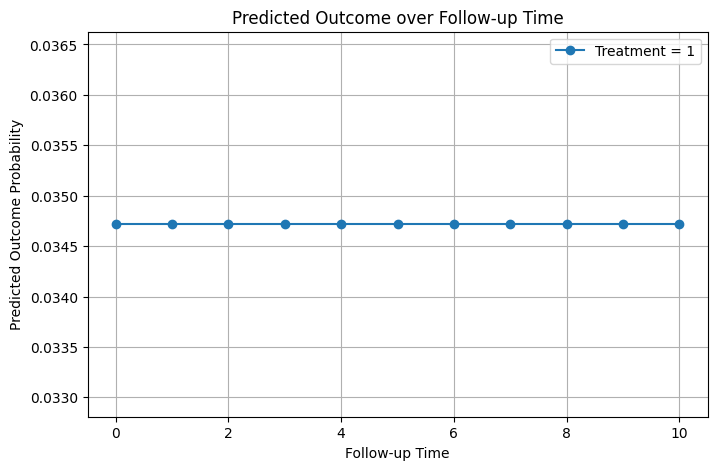

In [25]:
# Create a DataFrame for prediction.
# Here we generate predictions for followup times 0 through 10.
followup_times = np.arange(0, 11)
# For simplicity, use average values for x2 and set trial_period = 0.
pred_data = pd.DataFrame({
    'assigned_treatment': np.repeat(1, len(followup_times)),
    'x2': np.repeat(expanded_data['x2'].mean(), len(followup_times)),
    'followup_time': followup_times,
    'trial_period': np.repeat(0, len(followup_times))
})

# If your model had additional terms (e.g., polynomial terms), add them here.
pred_probs = msm_model.predict(pred_data)

# Plot the predicted outcome probability over follow-up time.
plt.figure(figsize=(8, 5))
plt.plot(followup_times, pred_probs, marker='o', label="Treatment = 1")
plt.xlabel("Follow-up Time")
plt.ylabel("Predicted Outcome Probability")
plt.title("Predicted Outcome over Follow-up Time")
plt.legend()
plt.grid(True)
plt.show()


## Conclusion

In this notebook (TTE‑v1) we have:
- Loaded and inspected the dummy data.
- Computed inverse probability of censoring weights (IPCW) using a logistic regression model.
- Expanded the data into a sequence of trial entries (for eligible patients).
- Fitted a weighted logistic regression model (marginal structural model) to estimate the causal effect of treatment.
- Generated predictions and plotted the predicted outcome probabilities over follow-up time.

This notebook serves as a foundational replication of the target trial emulation analysis in Python. For further refinement, you could extend the trial expansion logic to more closely mirror the R tutorial's detailed process and include additional covariates or model adjustments.


# User Prompts for TTE‑v1 Assistance

Below is a list of the prompts you provided that guided the creation of the TTE‑v1 analysis notebook. These prompts reflect the evolution of your request from the initial assignment details to the final production of a fully documented notebook.

1. **Initial Assignment Description**  
   > *"Assignment 1 for Clustering: New and novel methods in Machine Learning are made either by borrowing formulas and concepts from other scientific fields and redefining it based on new sets of assumptions, or by adding an extra step to an already existing framework of methodology.  
   >  
   > In this exercise (Assignment 1 of the Clustering Topic), we will try to develop a novel method of Target Trial Emulation by integrating concepts of Clustering into the already existing framework. Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs.  
   >  

2. **Request to “Do that assignment for me”**  
   > *"do that assignment for me just follow everything said in the instructions"*

3. **Request for a Step-by-Step Guide**  
   > *"wait so based off that tell me how to do that assignment step by step"*

4. **Clarification with R Tutorial Details**  
   > *"its this btw: Target Trial Emulation in R  
   > Alan Yang  
   > This tutorial outlines the steps for implementing a Target Trial Emulation in R using the TrialEmulation package.  
   > …"*

5. **R Installation Error Message**  
   > *"The downloaded binary packages are in  
   >         C:\Users\dylan\AppData\Local\Temp\RtmpsvkqRQ\downloaded_packages  
   > > data("data_censored", package="TrialEmulation")
   > Error in find.package(package, lib.loc, verbose = verbose) : 
   >  there is no package called ‘TrialEmulation’
   > > write.csv(data_censored, "data_censored.csv", row.names = FALSE)
   > Error in eval(expr, p) : object 'data_censored' not found"*

6. **Follow-Up Request for a From‑Scratch Guide**  
   > *"so from scratch give me a step by step way to do the assignment"*

7. **Request for the Full TTE‑v1 Notebook with Markdown**  
   > *"give me the full notebook for TTE-v1 with markdown already"*

8. **Request for a Full Documentation Notebook Structure**  
   > *"now the full Documentation notebook structure too please"*

9. **Request for All Prompts Used**  
   > *"give me the all the prompts i used to let you help me make TTE-v1 like an ai - assistant documention in markdown"*

---

*End of User Prompt Documentation*
